##**Transformer Architecture**

 "Attention Is All You Need" research paper - [Click here](https://arxiv.org/pdf/1706.03762)

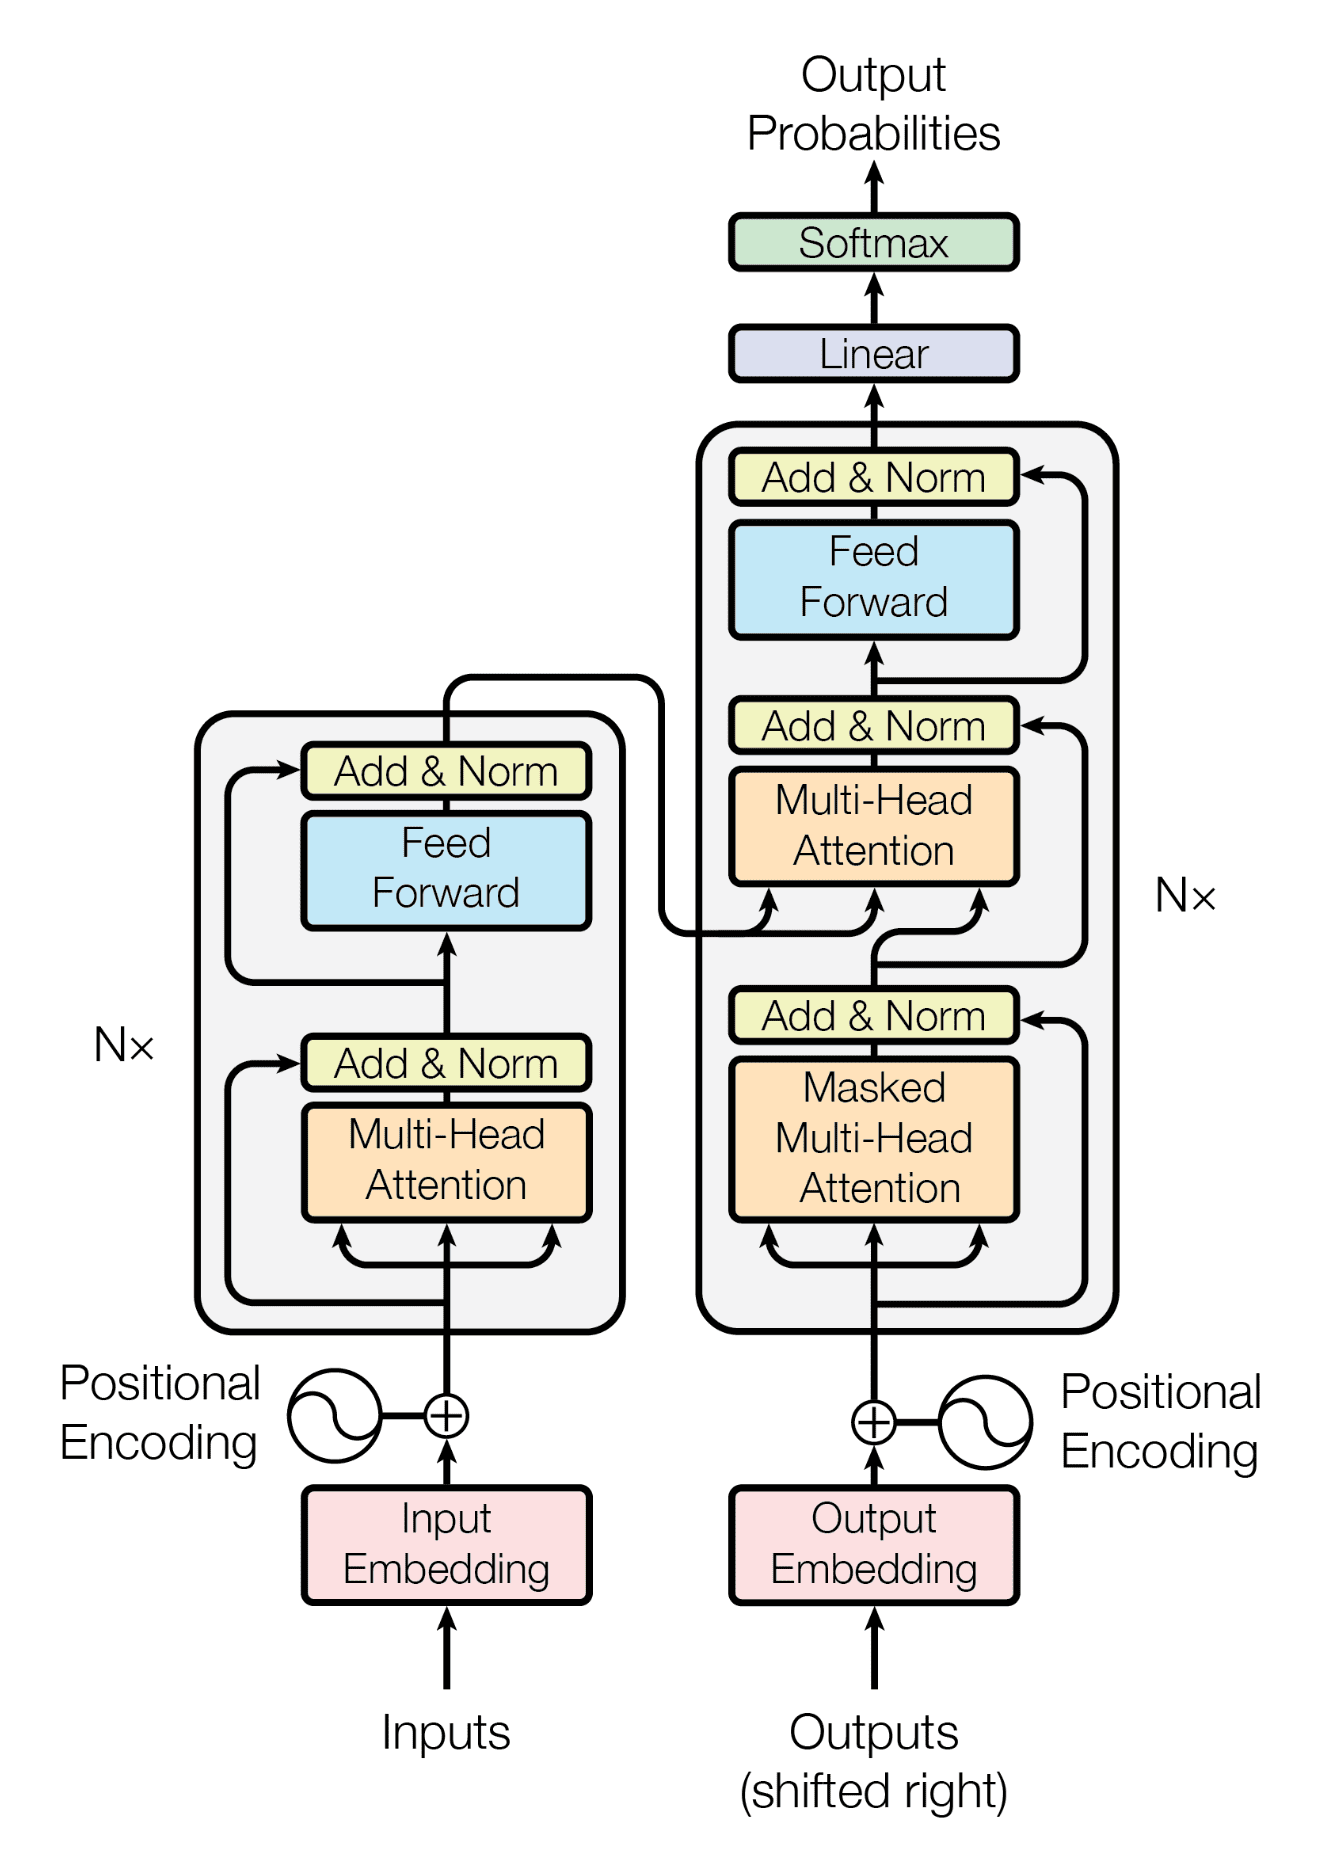

### Workflow of Transformers

1. **Input Representation**  
   - Tokenization  
   - Embedding Layer  
   - Positional Encoding  

2. **Encoder-Decoder Structure**  
   - **Encoder**:  
     - Multi-Head Self-Attention  
     - Feed-Forward Network (FFN)  
     - Add & Normalize  
   - **Decoder**:  
     - Masked Multi-Head Self-Attention  
     - Encoder-Decoder Attention  
     - Feed-Forward Network (FFN)  
     - Add & Normalize  

3. **Self-Attention Mechanism**  
   - Compute Queries (Q), Keys (K), and Values (V).  
   - Calculate attention scores.  

4. **Output Layer**  
   - Linear Layer  
   - Softmax Activation  

5. **Loss Function**  
   - Cross-Entropy Loss  

6. **Optimization**  
   - Adam Optimizer  
   - Gradient Descent with Learning Rate Scheduler  

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# all the important libraries from pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import math

#HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

#pathlib
from pathlib import Path

#typing
from typing import Any

#Library for progress bars in loops
from tqdm import tqdm

#importing library of warnings
import warnings

##**1. Input Embedding**

Input Embedding refers to the process of converting discrete input tokens (such as words, subwords, or characters) into continuous numerical vectors in a high-dimensional space that can be processed by the model. It is a key step in natural language processing tasks where textual data needs to be represented in a numerical format.

Key Points:
1. Mapping Tokens to Vectors: Each token is assigned a fixed-size dense vector.
2. Learnable Representations: These vectors are learnable parameters optimized during training.
3. Dimensionality: The size of the vector space is defined by the model (e.g., 512 or 768 dimensions).
4. Purpose: Captures semantic and syntactic relationships between tokens, allowing similar tokens to have closer embeddings in the vector space.

For example:

If "king" → [0.5, 0.8, ...] and "queen" → [0.4, 0.9, ...], their embeddings may reflect their relationship.

Embeddings are critical in enabling models to generalize across words with similar meanings.

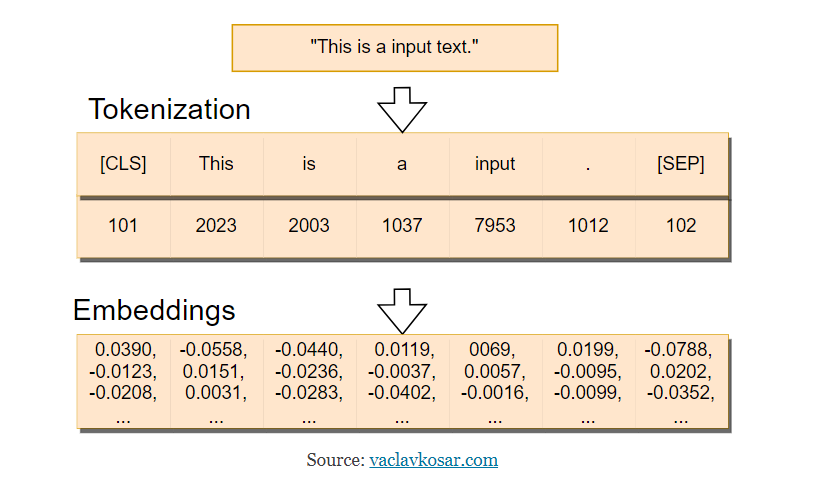

In [3]:
# Creating Input Embeddings
class InputEmbeddings(nn.Module):
  def __init__(self, d_model: int, vocab_size: int):
      super().__init__()
      self.d_model = d_model # Dimension of vectors (512)
      self.vocab_size = vocab_size # Size of the vocabulary
      self.embedding = nn.Embedding(vocab_size, d_model) # PyTorch layer that converts integer indices to dense embeddings

  def forward(self, x):
      return self.embedding(x) * math.sqrt(self.d_model) # Normalizing the variance of the embedding

In [4]:
# Example usage
i = InputEmbeddings(512, 30)
input_indices = torch.randint(0, 30, (5, 5)) # Example input: a batch of token indices
output_embeddings = i(input_indices)
print(output_embeddings.shape)  # Output shape should be (sequence_length, d_model)

torch.Size([5, 5, 512])


##**2. Positional Encoding**

Positional Encoding is a technique used in Transformer architectures to provide positional information to the model about the sequence of tokens, as Transformers lack inherent mechanisms (like RNNs or CNNs) to capture order or sequential relationships.

**Why is Positional Encoding Needed?**
1. Transformers Process Tokens in Parallel:
Transformers treat all tokens independently, so they lack a natural understanding of sequence order. Positional encoding helps the model differentiate between tokens based on their positions.

2. Order Matters in Language:
The meaning of a sequence depends on the order of its words, e.g., "I love cats" vs. "Cats love I".

**How Positional Encoding Works**

1. Formulation:
Positional encodings are added to input embeddings to inject position-specific information. These encodings are deterministic, fixed vectors.

2. Trigonometric Functions:
The positional encoding for each token is computed using sine and cosine functions of varying frequencies. For position
𝑝
𝑜
𝑠
pos and dimension
𝑖
i in the embedding:

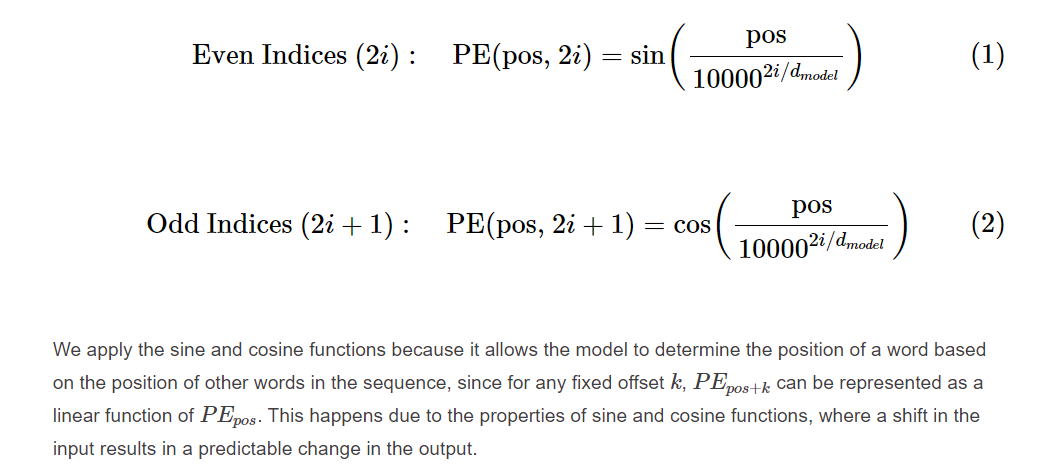

Here:

- 𝑝
𝑜
𝑠
pos: Token's position in the sequence.
𝑖

- i: Dimension index.
𝑑
𝑚
𝑜
𝑑
𝑒
𝑙
- d
model
​
 : Dimension of embeddings.


3. Addition to Input Embeddings:

Positional encodings are element-wise added to the input embeddings:

Input with Position
=
Embedding
+
Positional Encoding
Input with Position=Embedding+Positional Encoding

4. Key Properties:

- Periodic: Captures relative distances between positions.
- Fixed: No learnable parameters, avoiding the need to learn position information during training.


In [5]:
# Example
d_model = 6
max_sequence_length = 11

In [6]:
pe = torch.zeros(max_sequence_length, d_model)

In [7]:
pe

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [8]:
pos = torch.arange(0, max_sequence_length, dtype = torch.float)
pos

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [9]:
pos = pos.reshape(max_sequence_length, 1)

In [10]:
pos

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.]])

In [11]:
even_i = torch.arange(0, d_model, 2)
even_i

tensor([0, 2, 4])

In [12]:
even_denominator = torch.pow(10000, even_i/d_model)
even_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [13]:
odd_i = torch.arange(1, d_model, 2)
odd_i

tensor([1, 3, 5])

In [14]:
odd_denominator = torch.pow(10000, (odd_i - 1) / d_model)
odd_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [15]:
even_denominator == odd_denominator

tensor([True, True, True])

In [16]:
even_pe = torch.sin(pos / even_denominator)
even_pe

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194],
        [-0.5440,  0.4477,  0.0215]])

In [17]:
even_pe.shape

torch.Size([11, 3])

In [18]:
odd_pe = torch.cos(pos / odd_denominator)
odd_pe

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998],
        [-0.8391,  0.8942,  0.9998]])

In [19]:
odd_pe.shape

torch.Size([11, 3])

In [20]:
stacked = torch.stack([even_pe, odd_pe], dim = 2)

In [21]:
stacked, stacked.shape

(tensor([[[ 0.0000,  1.0000],
          [ 0.0000,  1.0000],
          [ 0.0000,  1.0000]],
 
         [[ 0.8415,  0.5403],
          [ 0.0464,  0.9989],
          [ 0.0022,  1.0000]],
 
         [[ 0.9093, -0.4161],
          [ 0.0927,  0.9957],
          [ 0.0043,  1.0000]],
 
         [[ 0.1411, -0.9900],
          [ 0.1388,  0.9903],
          [ 0.0065,  1.0000]],
 
         [[-0.7568, -0.6536],
          [ 0.1846,  0.9828],
          [ 0.0086,  1.0000]],
 
         [[-0.9589,  0.2837],
          [ 0.2300,  0.9732],
          [ 0.0108,  0.9999]],
 
         [[-0.2794,  0.9602],
          [ 0.2749,  0.9615],
          [ 0.0129,  0.9999]],
 
         [[ 0.6570,  0.7539],
          [ 0.3192,  0.9477],
          [ 0.0151,  0.9999]],
 
         [[ 0.9894, -0.1455],
          [ 0.3629,  0.9318],
          [ 0.0172,  0.9999]],
 
         [[ 0.4121, -0.9111],
          [ 0.4057,  0.9140],
          [ 0.0194,  0.9998]],
 
         [[-0.5440, -0.8391],
          [ 0.4477,  0.8942],
          

In [22]:
PE = torch.flatten(stacked, start_dim = 1, end_dim = 2)
PE, PE.shape

(tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
         [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
         [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
         [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
         [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
         [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
         [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
         [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
         [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998],
         [-0.5440, -0.8391,  0.4477,  0.8942,  0.0215,  0.9998]]),
 torch.Size([11, 6]))

In [23]:
# Creating the Positional Encoding
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
      super().__init__()
      self.d_model = d_model # Dimensionality of the model
      self.seq_len = seq_len # Maximum sequence length
      self.dropout = nn.Dropout(dropout) # Dropout layer to prevent overfitting

      # Creating a positional encoding matrix of shape (seq_len, d_model) filled with zeros
      pe = torch.zeros(seq_len, d_model)

      # Creating a tensor representing positions (0 to seq_len - 1)
      position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # Transforming 'position' into a 2D tensor['seq_len, 1']

      # Creating the division term for the positional encoding formula
      div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

      # Apply sine to even indices in pe
      pe[:, 0::2] = torch.sin(position * div_term)
      # Apply cosine to odd indices in pe
      pe[:, 1::2] = torch.cos(position * div_term)

      # Adding an extra dimension at the beginning of pe matrix for batch handling
      pe = pe.unsqueeze(0)

      # Registering 'pe' as buffer. Buffer is a tensor not considered as a model parameter
      self.register_buffer('pe', pe)

  def forward(self,x):
      # Addind positional encoding to the input tensor X
      x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
      return self.dropout(x) # Dropout for regularization

In [24]:
# Example usage
# Define parameters
d_model = 512
seq_len = 100
dropout = 0.1

# Create the PositionalEmbedding layer
pos_embed = PositionalEncoding(d_model, seq_len, dropout)

# Example input: A batch of embeddings
x = torch.randn(32, 50, d_model)

output = pos_embed(x)

In [25]:
output.shape

torch.Size([32, 50, 512])

##**3. Multi-head Attention**

###**`Self-Attention Mechanism`**

The self-attention mechanism is a pivotal component in Transformer architectures, enabling models to evaluate and assign varying levels of importance to different elements within a single input sequence. This mechanism allows each element to attend to all other elements, effectively capturing dependencies regardless of their positions.

**Key Features of Self-Attention:**

- Contextual Understanding: By attending to all tokens in the sequence, the model can grasp the context and meaning based on the relationships between words, which is crucial for tasks like language translation and text summarization.

- Position-Agnostic Dependencies: Self-attention allows the model to capture dependencies between tokens regardless of their positions, effectively handling long-range dependencies that are challenging for models like RNNs.

- Parallelization: Unlike sequential models, self-attention mechanisms can process tokens in parallel, leading to more efficient computation and training.

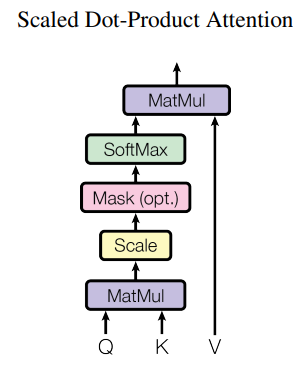

###**`Multi-Head Attention`**

Multi-Head Attention consists of several attention layers running in parallel.

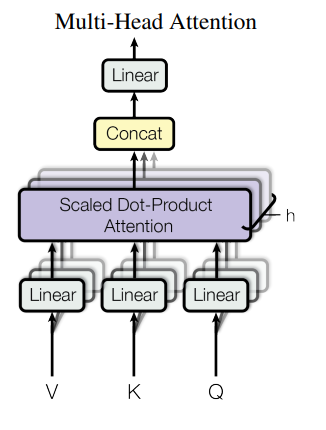

###**`Scaled-Dot attention`**

In [26]:
L = 11 # max sequence length
d_k = 6
d_v = 6

In [27]:
import numpy as np
q = np.random.randn(L, d_k)
k = np.random.randn(L, d_k)
v = np.random.randn(L, d_v)

In [28]:
q.shape, k.shape, v.shape

((11, 6), (11, 6), (11, 6))

In [29]:
k.T.shape

(6, 11)

In [30]:
o = np.matmul(q, k.T)
o.shape

(11, 11)

In [31]:
q.var(), k.var(), v.var(), np.matmul(q, k.T).var()

(0.9715936984911278, 1.104139783597788, 1.0761870377089306, 5.741228342666237)

In [32]:
scaled = np.matmul(q, k.T)
scaled.var()

5.741228342666237

In [33]:
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
scaled.var()

0.9568713904443729

In [34]:
def softmax(x):
  return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

In [35]:
x = np.array([1.0, 2.0, 3.0])
softmax(x)

array([0.09003057, 0.24472847, 0.66524096])

In [36]:
attention = softmax(scaled)
attention

array([[0.02062978, 0.11626   , 0.02008589, 0.05141426, 0.09451147,
        0.01197869, 0.02254745, 0.01608822, 0.47231941, 0.03924138,
        0.13492345],
       [0.01358627, 0.12584484, 0.09462395, 0.00965996, 0.01033349,
        0.00740837, 0.00269915, 0.00695216, 0.15699668, 0.51653174,
        0.05536339],
       [0.07458768, 0.1452978 , 0.15160576, 0.11500556, 0.05268633,
        0.02339542, 0.03759988, 0.01965799, 0.10004355, 0.20084547,
        0.07927456],
       [0.10558985, 0.0722201 , 0.05742182, 0.08991845, 0.11627103,
        0.0985019 , 0.1171194 , 0.1061103 , 0.09057939, 0.0527169 ,
        0.09355086],
       [0.07407282, 0.06843347, 0.08218532, 0.05387542, 0.12791338,
        0.08750936, 0.08298295, 0.13717696, 0.08028194, 0.08301254,
        0.12255583],
       [0.12359385, 0.18213748, 0.0361756 , 0.12263118, 0.06156846,
        0.0428905 , 0.07560622, 0.13601732, 0.05331597, 0.05497394,
        0.11108948],
       [0.02197093, 0.1109988 , 0.23748901, 0.1035421 , 0.

In [37]:
new_v = np.matmul(attention, v)
new_v

array([[-0.04630254, -0.34133299, -0.93955254,  0.0101894 , -0.27708044,
         0.23411597],
       [-0.73914767, -0.89073106,  0.02819509,  0.86021566, -0.93755368,
         0.12907574],
       [-0.10947929, -0.50552749,  0.00860451,  0.18164269, -0.2999523 ,
         0.02153413],
       [-0.1392146 , -0.19795411,  0.03767041, -0.10260382, -0.13599154,
         0.31362501],
       [-0.20416381, -0.14146149,  0.01462502,  0.00540659, -0.21426639,
         0.36467589],
       [-0.04086351, -0.16075024,  0.0200711 , -0.32732969,  0.13229615,
         0.20128617],
       [-0.01917715, -0.45436702,  0.16119094,  0.19358231, -0.3188422 ,
         0.21313796],
       [-0.62426221, -0.04974008,  0.09395019,  0.28215743, -0.38919047,
         0.11945125],
       [ 0.11583262, -0.47514879,  0.28117729,  0.07945533, -0.38705996,
         0.46239207],
       [-0.56182277,  0.2429832 ,  0.13558839, -0.35930164,  0.13412948,
         0.30403681],
       [-0.35079983, -0.02827705,  0.1355581 , -0.

In [38]:
new_v.shape

(11, 6)

###**`Multi-head Attention with Mask`**

Multi-head attention with masking is a fundamental component of Transformer architectures, particularly within the decoder, enabling models to process sequences efficiently during training and generate outputs autoregressively during inference.

**Key Concepts:**

- Multi-Head Attention: This mechanism allows the model to focus on different parts of the input sequence simultaneously by employing multiple attention heads. Each head learns distinct representations by attending to various positions within the sequence.
TOWARDS DATA SCIENCE

- Masking: In the context of sequence generation, masking ensures that the model does not have access to future tokens that it should not consider. This is achieved by applying a mask that prevents attention to subsequent positions in the sequence, maintaining the autoregressive property during inference.

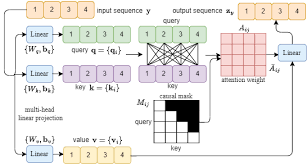

In [39]:
mask = np.tril(np.ones((L, L)))
mask

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [40]:
mask[mask == 0] = np.inf
mask[mask == 1] = 0

In [41]:
mask

array([[ 0., inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [ 0.,  0., inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [ 0.,  0.,  0., inf, inf, inf, inf, inf, inf, inf, inf],
       [ 0.,  0.,  0.,  0., inf, inf, inf, inf, inf, inf, inf],
       [ 0.,  0.,  0.,  0.,  0., inf, inf, inf, inf, inf, inf],
       [ 0.,  0.,  0.,  0.,  0.,  0., inf, inf, inf, inf, inf],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., inf, inf, inf, inf],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., inf, inf, inf],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., inf, inf],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., inf],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

(-0.5, 10.5, 10.5, -0.5)

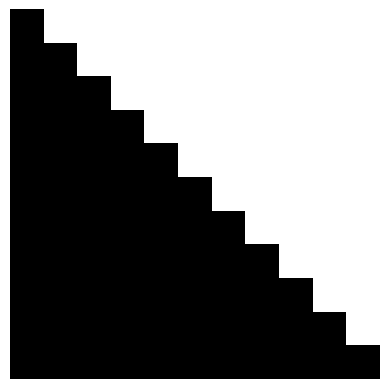

In [42]:
import matplotlib.pyplot as plt
plt.imshow(mask, cmap = 'gray')
plt.axis(False)

In [43]:
scaled = np.matmul(q, k.T) / math.sqrt(d_k)

In [44]:
masked_scaled = scaled + mask

In [45]:
masked_scaled

array([[-1.67690737,         inf,         inf,         inf,         inf,
                inf,         inf,         inf,         inf,         inf,
                inf],
       [-1.40517401,  0.82081611,         inf,         inf,         inf,
                inf,         inf,         inf,         inf,         inf,
                inf],
       [-0.7546293 , -0.08781921, -0.04532112,         inf,         inf,
                inf,         inf,         inf,         inf,         inf,
                inf],
       [ 0.22717402, -0.1526698 , -0.38196394,  0.06651486,         inf,
                inf,         inf,         inf,         inf,         inf,
                inf],
       [ 0.25634483,  0.17715816,  0.36027277, -0.06202957,  0.80264943,
                inf,         inf,         inf,         inf,         inf,
                inf],
       [ 0.314985  ,  0.70274596, -0.91363089,  0.30716546, -0.38186608,
        -0.74336557,         inf,         inf,         inf,         inf,
              

In [46]:
masked_scaled = torch.tensor(masked_scaled, dtype=torch.float32)

In [47]:
masked_scaled

tensor([[-1.6769,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
             inf,     inf,     inf],
        [-1.4052,  0.8208,     inf,     inf,     inf,     inf,     inf,     inf,
             inf,     inf,     inf],
        [-0.7546, -0.0878, -0.0453,     inf,     inf,     inf,     inf,     inf,
             inf,     inf,     inf],
        [ 0.2272, -0.1527, -0.3820,  0.0665,     inf,     inf,     inf,     inf,
             inf,     inf,     inf],
        [ 0.2563,  0.1772,  0.3603, -0.0620,  0.8026,     inf,     inf,     inf,
             inf,     inf,     inf],
        [ 0.3150,  0.7027, -0.9136,  0.3072, -0.3819, -0.7434,     inf,     inf,
             inf,     inf,     inf],
        [-0.8869,  0.7329,  1.4935,  0.6633,  0.3746, -0.3900, -0.0483,     inf,
             inf,     inf,     inf],
        [ 1.7693, -0.3082,  1.2664, -1.3381,  1.2091,  0.8831,  0.1335,  1.0646,
             inf,     inf,     inf],
        [-1.1584, -1.0644,  1.3232,  1.0354,  1.1400,  1

In [48]:
# Replace infinity with a very large negative value
masked_scaled = masked_scaled.masked_fill(masked_scaled == float('inf'), float('-inf'))

In [49]:
masked_scaled

tensor([[-1.6769,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [-1.4052,  0.8208,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [-0.7546, -0.0878, -0.0453,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [ 0.2272, -0.1527, -0.3820,  0.0665,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [ 0.2563,  0.1772,  0.3603, -0.0620,  0.8026,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [ 0.3150,  0.7027, -0.9136,  0.3072, -0.3819, -0.7434,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [-0.8869,  0.7329,  1.4935,  0.6633,  0.3746, -0.3900, -0.0483,    -inf,
            -inf,    -inf,    -inf],
        [ 1.7693, -0.3082,  1.2664, -1.3381,  1.2091,  0.8831,  0.1335,  1.0646,
            -inf,    -inf,    -inf],
        [-1.1584, -1.0644,  1.3232,  1.0354,  1.1400,  1

In [50]:
import torch.nn.functional as F
masked_attention = F.softmax(masked_scaled, dim=-1)

In [51]:
print("Masked Attention:\n", masked_attention)

Masked Attention:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0974, 0.9026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.2008, 0.3911, 0.4081, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.3247, 0.2221, 0.1766, 0.2765, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.1822, 0.1684, 0.2022, 0.1325, 0.3147, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.2172, 0.3201, 0.0636, 0.2155, 0.1082, 0.0754, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0344, 0.1738, 0.3719, 0.1622, 0.1215, 0.0566, 0.0796, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.2901, 0.0363, 0.1754, 0.0130, 0.1657, 0.1196, 0.0565, 0.1434, 0.0000,
         0.0000, 0.0000],
        [0.0153, 0.0169, 0.1835, 0.1376, 0.1528, 0.1872, 0.2030, 0.0408, 0.0630,
         0.0000, 0.0000],
        [0.3129, 0

In [52]:
new_v = np.matmul(masked_attention, v)

In [53]:
new_v

tensor([[-1.5395,  1.4938, -0.1252, -0.9040,  0.9951, -0.9733],
        [ 0.2399,  0.4834, -0.7128, -1.2389,  1.1784, -0.0454],
        [-0.1600,  0.3771, -0.1966, -0.4503,  0.4502,  0.0083],
        [ 0.3127, -0.0192,  0.0950, -0.6890,  0.6070, -0.4650],
        [ 0.3627,  0.0347, -0.0740, -0.3278,  0.3747, -0.3721],
        [ 0.4522,  0.1362, -0.1094, -0.7336,  0.6044, -0.3232],
        [ 0.4256, -0.3687,  0.1942, -0.1228,  0.0086,  0.1112],
        [-0.4327,  0.5141,  0.0970, -0.3444,  0.1968,  0.2425],
        [ 0.1684, -0.4640,  0.2915,  0.0080, -0.3345,  0.5081],
        [-0.5860,  0.2438,  0.1817, -0.4472,  0.2058,  0.3708],
        [-0.3508, -0.0283,  0.1356, -0.1343, -0.0903,  0.2564]],
       dtype=torch.float64)

###**`Multi-Head Attention without Mask`**

Multi-head attention is a fundamental component of Transformer architectures, enabling models to capture intricate relationships within input sequences by attending to different parts of the sequence simultaneously

**How It Works:**

1. Linear Projections:
- The input embeddings are linearly projected into multiple sets of queries (Q), keys (K), and values (V).

2. Parallel Attention Heads:
- Each set undergoes an independent scaled dot-product attention calculation, allowing the model to focus on various aspects of the input.

3. Concatenation and Final Linear Projection:
- The outputs from all attention heads are concatenated and passed through a final linear layer, integrating the information from different representation subspaces.

**Benefits:**

- Diverse Representations: By attending to information from different representation subspaces at various positions, multi-head attention enables the model to capture a range of dependencies and patterns within the data.

- Enhanced Learning Capacity: This mechanism allows the model to jointly attend to information from different representation subspaces at different positions, enhancing its ability to understand complex dependencies.

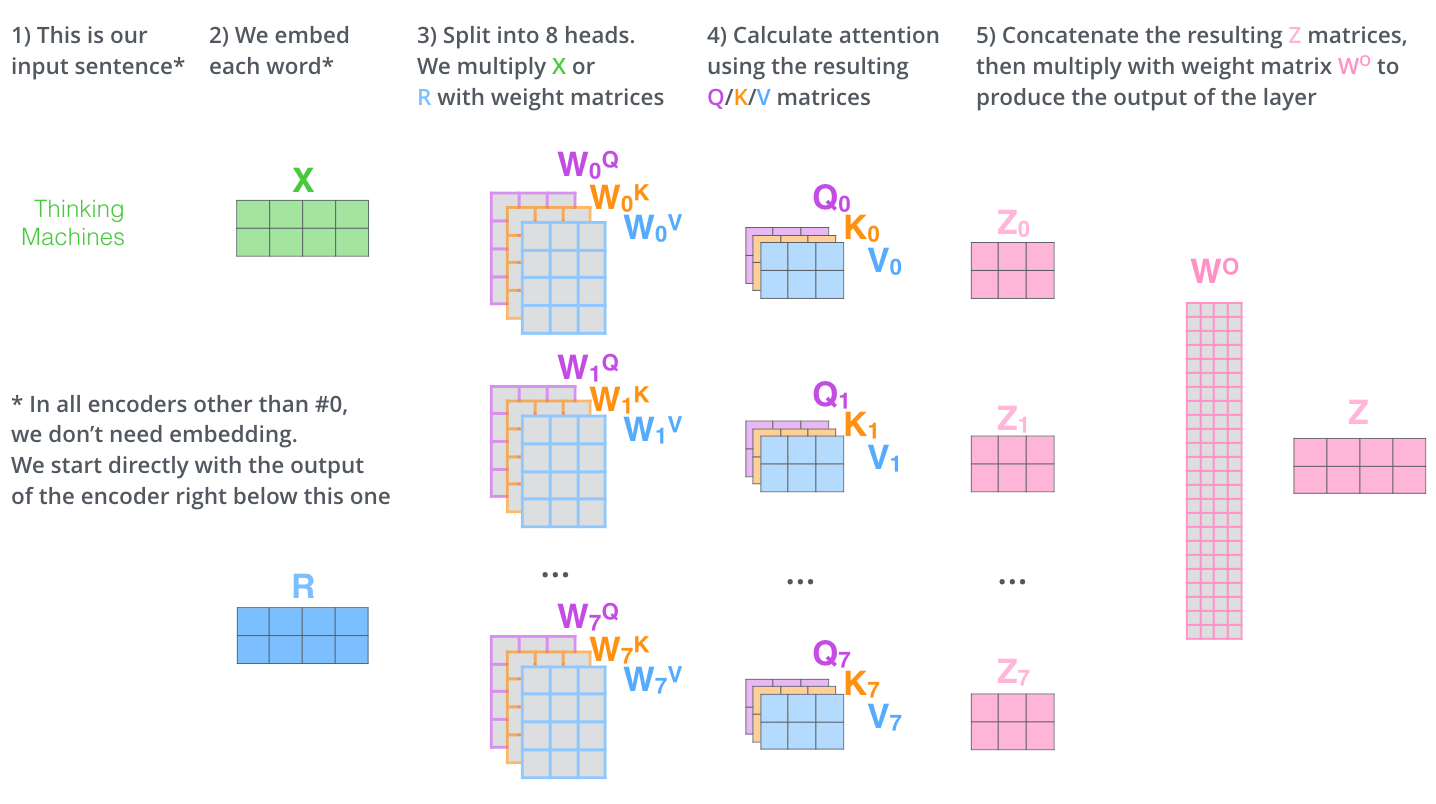

###**`Self-Attention Mechanism`**
The self-attention mechanism is a pivotal component in modern neural network architectures, particularly Transformers, enabling models to evaluate and assign varying levels of importance to different elements within a single input sequence. This mechanism allows the model to capture intricate dependencies and relationships, enhancing its ability to understand context and meaning.

**Why Is It Called "Self-Attention"?**

The term "self" signifies that the attention mechanism is applied within the same sequence, meaning each element (e.g., a word in a sentence) attends to all other elements in that sequence. This contrasts with traditional attention mechanisms that operate between separate sequences, such as between an input and an output sequence. By focusing internally, self-attention enables the model to dynamically adjust the influence of each element based on its relevance to others, effectively capturing contextual relationships.

**How Does Self-Attention Work?**

In self-attention, each element in the sequence is represented by three vectors: Query (Q), Key (K), and Value (V). The attention scores are computed by taking the dot product of the Query vector with all Key vectors, determining how much focus each element should have on others. These scores are then normalized using a softmax function to produce attention weights, which are applied to the Value vectors to generate a weighted sum. This process results in a new representation for each element, enriched with contextual information from the entire sequence.

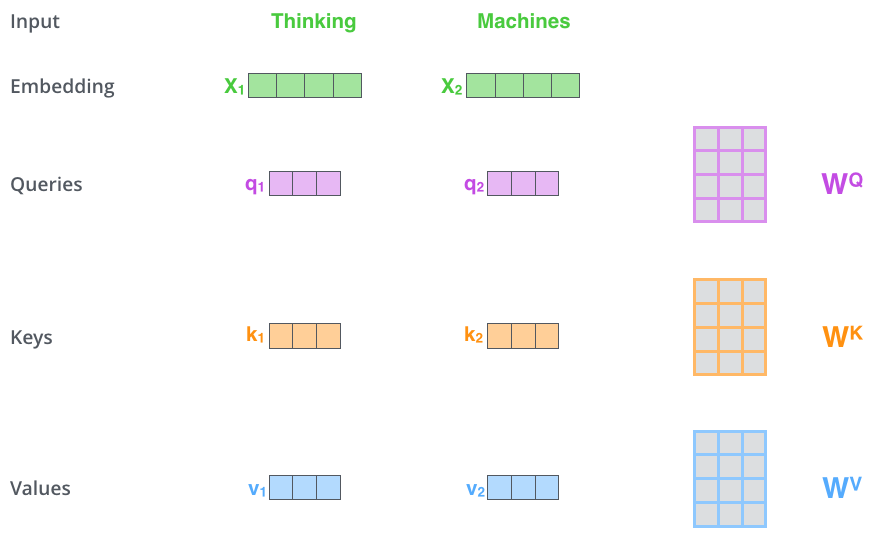

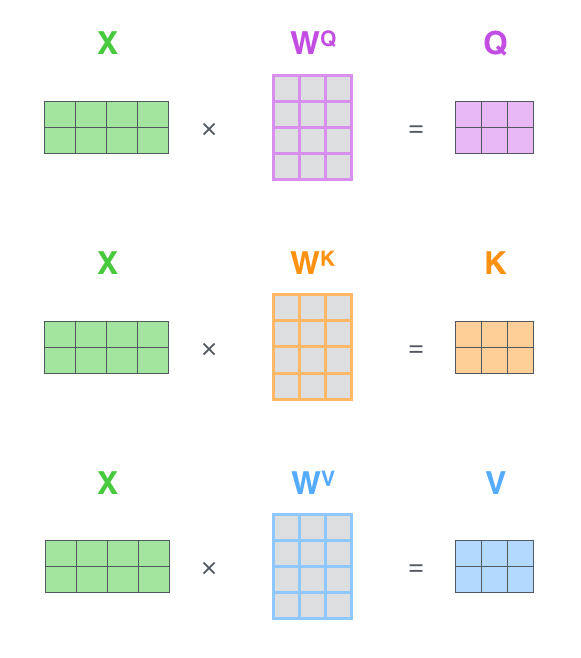

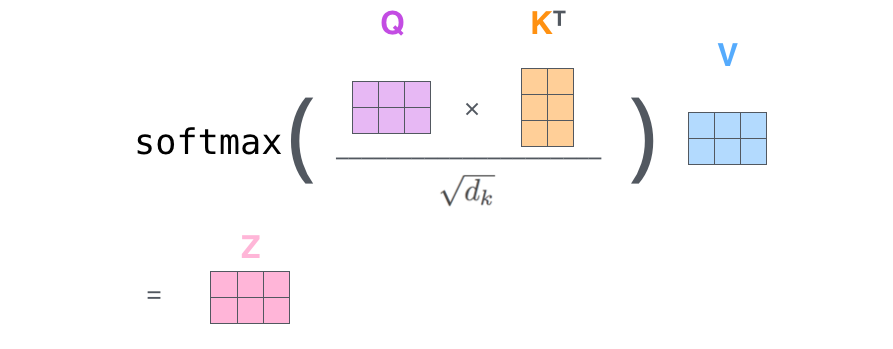

In [54]:
sequence_length = 11
batch_size = 1
input_dim = 512
d_model = 512

x = torch.randn((1, sequence_length, input_dim))

In [55]:
print(x)
print(f"Shape of the x is:\n {x.shape}")

tensor([[[ 1.4679, -1.7389,  0.4351,  ..., -0.6640,  1.5981, -0.0532],
         [-1.2822, -0.1150, -1.6201,  ...,  0.6142,  0.7255,  1.1739],
         [-0.2810, -1.1535, -0.7967,  ...,  1.9671,  0.1647,  0.6995],
         ...,
         [ 0.2738,  0.5352, -0.4073,  ..., -1.1325, -0.3685,  0.0030],
         [ 0.0903,  0.7965,  0.4475,  ..., -0.0645, -1.3498, -0.3344],
         [-0.6286,  0.5490, -0.3947,  ..., -0.2704,  0.1697, -1.2678]]])
Shape of the x is:
 torch.Size([1, 11, 512])


In [56]:
qkv_layer = nn.Linear(in_features = input_dim, out_features = 3 * d_model)

In [57]:
qkv_layer

Linear(in_features=512, out_features=1536, bias=True)

In [58]:
qkv = qkv_layer(x)

In [59]:
qkv.shape

torch.Size([1, 11, 1536])

In [60]:
num_heads = 8
head_dim = d_model // num_heads

In [61]:
head_dim

64

In [62]:
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim) # (1, 11, 8, 3 * 64)

In [63]:
qkv.shape

torch.Size([1, 11, 8, 192])

In [64]:
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 11, 192])

In [65]:
q, k, v = qkv.chunk(3, dim = -1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 11, 64]),
 torch.Size([1, 8, 11, 64]),
 torch.Size([1, 8, 11, 64]))

In [66]:
k.transpose(-2, -1).shape

torch.Size([1, 8, 64, 11])

In [67]:
torch.matmul(q, k.transpose(-2, -1))

tensor([[[[ 5.3475, -0.4691,  3.9517,  1.2823, -2.6519, -4.2612, 10.2354,
            2.9200, -1.7953,  4.4467, -1.6777],
          [-2.4696,  0.0767, -0.7107,  4.5593, -0.0509, -0.7335, -0.3182,
            6.9119,  1.2522,  1.8781, -1.7458],
          [ 1.0801, -0.9726,  0.9712, -0.9923, -1.2730, -5.0332,  2.7647,
            1.7225,  4.8442,  1.5873, -0.0378],
          [ 0.4263,  4.5960, -3.3668, -1.0593, -2.4605,  2.6405,  1.7329,
            1.4070, -3.8090,  0.6571, -0.5747],
          [-2.9840,  0.1371, -1.9236,  6.0095, -0.8810, -0.8879,  1.9051,
            1.9257, -2.6204,  1.5844, -2.9040],
          [ 0.4633, -3.2197,  1.5306,  1.4834, -1.8430, -1.3877,  2.3409,
            2.8230, -1.5261, -3.4809,  3.4137],
          [-0.3303, -0.1455, -5.5296, -2.3125,  0.0687,  1.5796, -2.7706,
            2.4466, -3.2273,  3.4823,  3.2830],
          [-3.7021, -1.8933, -2.4935, -0.2846,  4.2334,  0.4469, -2.1437,
            2.0412, -1.3039, -1.8878,  1.8214],
          [ 0.5671, -0.8

In [68]:
torch.matmul(q, k.transpose(-2, -1)).shape

torch.Size([1, 8, 11, 11])

In [69]:
d_k = k.size()[-1]
d_k

64

In [70]:
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

In [71]:
scaled.shape

torch.Size([1, 8, 11, 11])

In [72]:
mask = torch.full(scaled.size(), float('-inf'))
mask

tensor([[[[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]],

         [[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -in

In [73]:
mask = torch.triu(mask, diagonal = 1)
mask[0][0]

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [74]:
(scaled + mask)[0][0]

tensor([[ 0.6684,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [-0.3087,  0.0096,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [ 0.1350, -0.1216,  0.1214,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [ 0.0533,  0.5745, -0.4208, -0.1324,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [-0.3730,  0.0171, -0.2404,  0.7512, -0.1101,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [ 0.0579, -0.4025,  0.1913,  0.1854, -0.2304, -0.1735,    -inf,    -inf,
            -inf,    -inf,    -inf],
        [-0.0413, -0.0182, -0.6912, -0.2891,  0.0086,  0.1975, -0.3463,    -inf,
            -inf,    -inf,    -inf],
        [-0.4628, -0.2367, -0.3117, -0.0356,  0.5292,  0.0559, -0.2680,  0.2552,
            -inf,    -inf,    -inf],
        [ 0.0709, -0.1059,  0.5375, -0.0090,  0.0810, -0

In [75]:
scaled += mask

In [76]:
scaled

tensor([[[[ 0.6684,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
              -inf,    -inf,    -inf,    -inf],
          [-0.3087,  0.0096,    -inf,    -inf,    -inf,    -inf,    -inf,
              -inf,    -inf,    -inf,    -inf],
          [ 0.1350, -0.1216,  0.1214,    -inf,    -inf,    -inf,    -inf,
              -inf,    -inf,    -inf,    -inf],
          [ 0.0533,  0.5745, -0.4208, -0.1324,    -inf,    -inf,    -inf,
              -inf,    -inf,    -inf,    -inf],
          [-0.3730,  0.0171, -0.2404,  0.7512, -0.1101,    -inf,    -inf,
              -inf,    -inf,    -inf,    -inf],
          [ 0.0579, -0.4025,  0.1913,  0.1854, -0.2304, -0.1735,    -inf,
              -inf,    -inf,    -inf,    -inf],
          [-0.0413, -0.0182, -0.6912, -0.2891,  0.0086,  0.1975, -0.3463,
              -inf,    -inf,    -inf,    -inf],
          [-0.4628, -0.2367, -0.3117, -0.0356,  0.5292,  0.0559, -0.2680,
            0.2552,    -inf,    -inf,    -inf],
          [ 0.0709, -0.1

In [77]:
attention = F.softmax(scaled, dim = -1)

In [78]:
attention.shape

torch.Size([1, 8, 11, 11])

In [79]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.4211, 0.5789, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.3623, 0.2803, 0.3574, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.2417, 0.4071, 0.1505, 0.2008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.1250, 0.1847, 0.1428, 0.3848, 0.1626, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.1834, 0.1157, 0.2096, 0.2083, 0.1375, 0.1455, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.1566, 0.1603, 0.0818, 0.1223, 0.1647, 0.1989, 0.1155, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0794, 0.0996, 0.0924, 0.1217, 0.2142, 0.1334, 0.0965, 0.1628, 0.0000,
         0.0000, 0.0000],
        [0.1245, 0.1043, 0.1985, 0.1149, 0.1257, 0.1104, 0.0829, 0.0627, 0.0760,
         0.0000, 0.0000],
        [0.0666, 0.2064, 0.0777, 0.08

In [80]:
values = torch.matmul(attention, v)

In [81]:
values.shape

torch.Size([1, 8, 11, 64])

####**`Implementing Multi-Head Attention with Mask and without Mask`**

In [82]:
# Creating the Multi-Head Attention block
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, d_model: int, h: int, dropout: float) -> None: # h = number of heads
      super().__init__()
      self.d_model = d_model
      self.h = h

      # We ensure that the dimensions of the model is divisible by the number of heads
      assert d_model % h == 0, 'd_model is not divisible by h'

      # d_k is the dimension of each attention head's key, query, and value vectors
      self.d_k = d_model // h # d_k formula, like in the original "Attention Is All You Need" paper

      # Defining the weight matrices
      self.w_q = nn.Linear(d_model, d_model) # W_q
      self.w_k = nn.Linear(d_model, d_model) # W_k
      self.w_v = nn.Linear(d_model, d_model) # W_v
      self.w_o = nn.Linear(d_model, d_model) # W_o

      self.dropout = nn.Dropout(dropout) # Dropout layer to avoid overfitting


  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):# mask => When we want certain words to NOT interact with others, we "hide" them

      d_k = query.shape[-1] # The last dimension of query, key, and value

      # We calculate the Attention(Q,K,V) as in the formula in the image above
      attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k) # @ = Matrix multiplication sign in PyTorch

      # Before applying the softmax, we apply the mask to hide some interactions between words
      if mask is not None: # If a mask IS defined...
          attention_scores.masked_fill_(mask == 0, -1e9) # Replace each value where mask is equal to 0 by -1e9
      attention_scores = attention_scores.softmax(dim = -1) # Applying softmax
      if dropout is not None: # If a dropout IS defined...
          attention_scores = dropout(attention_scores) # We apply dropout to prevent overfitting

      return (attention_scores @ value), attention_scores # Multiply the output matrix by the V matrix, as in the formula

  def forward(self, q, k, v, mask):

      query = self.w_q(q) # Q' matrix
      key = self.w_k(k) # K' matrix
      value = self.w_v(v) # V' matrix


      # Splitting results into smaller matrices for the different heads
      # Splitting embeddings (third dimension) into h parts
      query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
      key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
      value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension

      # Obtaining the output and the attention scores
      x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

      # Obtaining the H matrix
      x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

      return self.w_o(x) # Multiply the H matrix by the weight matrix W_o, resulting in the MH-A matrix

###**`Layer Normalization`**

Layer normalization is a crucial component in transformer architectures, playing a significant role in stabilizing and accelerating the training process. Unlike batch normalization, which normalizes across a mini-batch, layer normalization operates independently for each data sample, normalizing across the features within a layer. This characteristic makes it particularly suitable for transformer models, which often process variable-length sequences and may operate with small batch sizes.

Transformers process sequences of varying lengths and often operate with small batch sizes, making batch normalization less effective. Layer normalization does not depend on batch size and normalizes across the features within a single data sample, making it more suitable for transformer architectures.

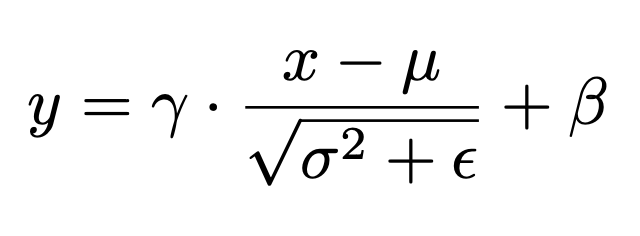

- x(i) is the
𝑖
i-th feature of the input vector.

- μ is the mean of the input features.

- σ
2
  is the variance of the input features.

- By adding
ϵ, we ensure that the denominator is always positive, preventing potential issues during the division.

- Scaling and Shifting (y): Applies learnable parameters
𝛾
γ and
𝛽
β to the normalized activations, allowing the network to adjust the normalized values as needed for optimal performance.

In [83]:
# Creating Layer Normalization
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6) -> None: #0.000001 to avoid division by zero
        super().__init__()
        self.eps = eps

        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1)) # One-dimensional tensor that will be used to scale the input data

        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1)) # One-dimensional tensor that will be added to the input data

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True) # Computing the mean of the input data. Keeping the number of dimensions unchanged
        std = x.std(dim = -1, keepdim = True) # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged

        # Returning the normalized input
        return self.alpha * (x-mean) / (std + self.eps) + self.bias

##**`Feed Forward Network`**

In Transformer architectures, the feed-forward network (FFN) is a crucial component that processes each position's representation independently after the self-attention mechanism. This operation enhances the model's capacity to capture complex patterns and relationships within the data.

**`Structure of the Feed-Forward Network:`**

The FFN consists of two linear transformations with a non-linear activation function applied between them. Mathematically, for an input vector x, the FFN can be represented as:

FFN
(
𝑥
)
=
max
⁡
(
0
,
𝑥
𝑊
1
+
𝑏
1
)
𝑊
2
+
𝑏
2
FFN(x)=max(0,xW
1
​
 +b
1
​
 )W
2
​
 +b
2
​

Where:

- 𝑊
1
W
1
​
  and
𝑊
2
W
2
​
  are weight matrices.

- 𝑏
1
b
1
​
  and
𝑏
2
b
2
​
  are bias vectors.

- max
⁡
(
0
,
⋅
)
max(0,⋅) denotes the ReLU activation function.

The FFN operates independently on each position's representation, enabling the model to apply non-linear transformations to the features extracted by the self-attention mechanism. This process allows the Transformer to capture intricate patterns and relationships within the data, contributing to its effectiveness in tasks like language modeling and machine translation.

In [84]:
# Creating Feed Forward Layers
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
      super().__init__()
      # First linear transformation
      self.linear_1 = nn.Linear(d_model, d_ff) # W1 & b1
      self.dropout = nn.Dropout(dropout) # Dropout to prevent overfitting
      # Second linear transformation
      self.linear_2 = nn.Linear(d_ff, d_model) # W2 & b2

  def forward(self, x):
      # (Batch, seq_len, d_model) --> (batch, seq_len, d_ff) -->(batch, seq_len, d_model)
      return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [85]:
!pip install torchinfo

In [86]:
model = FeedForwardBlock(d_model=512, d_ff=2048, dropout=0.1)

In [87]:
model

FeedForwardBlock(
  (linear_1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear_2): Linear(in_features=2048, out_features=512, bias=True)
)

In [88]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
FeedForwardBlock                         --
├─Linear: 1-1                            1,050,624
├─Dropout: 1-2                           --
├─Linear: 1-3                            1,049,088
Total params: 2,099,712
Trainable params: 2,099,712
Non-trainable params: 0

###**`Residual Connection`**

In Transformer architectures, residual connections are integral components that facilitate the flow of information across layers, thereby enhancing the model's performance and training efficiency.

A residual connection involves adding the input of a layer to its output, creating a shortcut that allows the input to bypass certain transformations. Mathematically, if x is the input and F(x) is the output of a layer, the residual connection computes:

**Role in Transformers:**

In Transformers, residual connections are employed in both the encoder and decoder components, particularly around the self-attention and feed-forward sub-layers. Each sub-layer's output is added to its input, followed by layer normalization. This design choice offers several advantages:

- 1. Mitigation of Vanishing Gradient Problem
- 2. Enhanced Gradient Flow
- 3. Improved Representational Capacity
- 4. Robustness and Regularization

**Implementation in Transformer Architecture:**

In transformers, residual connections are employed around sub-layers within both the encoder and decoder. Each sub-layer (such as self-attention or feed-forward networks) is wrapped with a residual connection followed by layer normalization. This design can be represented as:

LayerNorm
(
𝑥
+
Sublayer
(
𝑥
)
)
LayerNorm(x+Sublayer(x))

Here,
𝑥
x is the input to the sub-layer, and
Sublayer
(
𝑥
)
Sublayer(x) is the output from the sub-layer's operations. The addition
𝑥
+
Sublayer
(
𝑥
)
x+Sublayer(x) constitutes the residual connection, and applying
LayerNorm
LayerNorm ensures that the combined output is normalized, promoting stable training.

In [89]:
# Building Residual Connection
class ResidualConnection(nn.Module):
  def __init__(self, dropout: float) -> None:
      super().__init__()
      self.dropout = nn.Dropout(dropout) # We use a dropout layer to prevent overfitting
      self.norm = LayerNormalization() # We use a normalization layer

  def forward(self, x, sublayer):
      # We normalize the input and add it to the original input 'x'. This creates the residual connection process.
      return x + self.dropout(sublayer(self.norm(x)))

##**`Encoder Block`**

The encoder block is a fundamental component responsible for processing input sequences and generating continuous representations that capture contextual information for each token. This process is crucial for understanding the relationships and dependencies within the input data.

**Structure of an Encoder Block:**

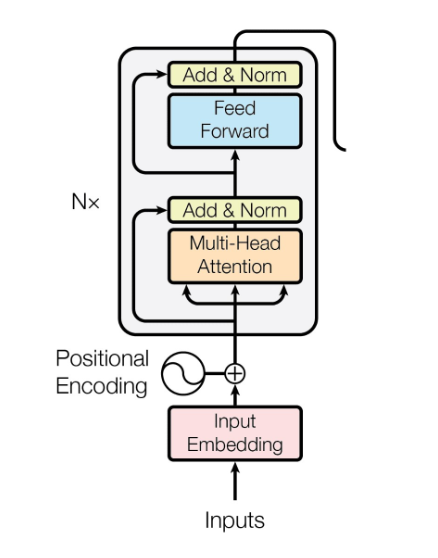

An encoder block typically comprises the following sub-layers:

1. Multi-Head Self-Attention Mechanism:

- This mechanism allows the model to focus on different parts of the input sequence simultaneously, capturing various aspects of the relationships between tokens.
- It computes attention scores to weigh the significance of each token relative to others, enabling the model to understand contextual relevance.

2. Feed-Forward Neural Network:

- A position-wise fully connected network applied to the output of the self-attention layer.
- It introduces non-linearity and performs complex transformations to enhance the representation of the input data.

3. Add & Norm Layers:

- Residual connections (skip connections) are employed around each sub-layer, followed by layer normalization.
- These components help in stabilizing and accelerating the training process by ensuring better gradient flow and maintaining the integrity of the input information.

**Workflow within an Encoder Block:**

1. Input Embedding and Positional Encoding:

- The input tokens are first converted into embeddings, which are then combined with positional encodings to incorporate information about the position of each token in the sequence.

2. Self-Attention Calculation:

- The embeddings are processed through the multi-head self-attention mechanism, allowing the model to weigh the importance of different tokens relative to each other.

3. Feed-Forward Processing:

- The output from the self-attention layer is passed through the feed-forward neural network for further transformation.

4. Residual Connections and Layer Normalization:

- Residual connections add the input of each sub-layer to its output, and layer normalization is applied to maintain stability and facilitate training.

This modular design enables the encoder to effectively capture complex patterns and dependencies within the input sequence, making it a powerful tool for various tasks in natural language processing and beyond.

In [90]:
# Building Encoder Block
class EncoderBlock(nn.Module):
  # This block takes in the MultiHeadAttentionBlock and FeedForwardBlock, as well as the dropout rate for the residual connections
  def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
      super().__init__()
      # Storing the self-attention block and feed-forward block
      self.self_attention_block = self_attention_block
      self.feed_forward_block = feed_forward_block
      self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)]) # 2 Residual Connections with dropout

  def forward(self, x, src_mask):
      # Applying the first residual connection with the self-attention block
      x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask)) # Three 'x's corresponding to query, key, and value inputs plus source mask

      # Applying the second residual connection with the feed-forward block
      x = self.residual_connections[1](x, self.feed_forward_block)
      return x # Output tensor after applying self-attention and feed-forward layers with residual connections.

In [91]:
# Building Encoder
# An Encoder can have several Encoder Blocks
class Encoder(nn.Module):
  # The Encoder takes in instances of 'EncoderBlock'
  def __init__(self, layers: nn.ModuleList) -> None:
      super().__init__()
      self.layers = layers # Storing the EncoderBlocks
      self.norm = LayerNormalization() # Layer for the normalization of the output of the encoder layers

  def forward(self, x, mask):
      # Iterating over each EncoderBlock stored in self.layers
      for layer in self.layers:
          x = layer(x, mask) # Applying each EncoderBlock to the input tensor 'x'
      return self.norm(x) # Normalizing output

##**`Decoder`**

The decoder plays a crucial role in generating output sequences by interpreting the encoded input representations and producing one token at a time. This process is essential in tasks such as machine translation, text generation, and other sequence-to-sequence applications.

**Structure of the Transformer Decoder:**

The transformer decoder is composed of multiple layers, each containing the following sub-layers:

1. Masked Multi-Head Self-Attention:

- This mechanism allows the decoder to attend to previous positions in the output sequence, enabling it to generate the next token based on the tokens generated so far.
- The masking ensures that the decoder does not attend to subsequent positions, maintaining the autoregressive property necessary for sequential generation.

2. Multi-Head Cross-Attention (Encoder-Decoder Attention):

- This layer enables the decoder to focus on relevant parts of the input sequence by attending to the encoder's output representations.
- It facilitates the alignment between the input and output sequences, ensuring that the generated output is contextually appropriate.

3. Feed-Forward Neural Network:

- A position-wise fully connected network that introduces non-linearity and performs complex transformations on the data.
- This sub-layer enhances the model's capacity to capture intricate patterns and dependencies.

4. Add & Norm Layers:

- Residual connections (skip connections) are employed around each sub-layer, followed by layer normalization.
- These components help stabilize and accelerate the training process by ensuring better gradient flow and maintaining the integrity of the input information.

**Workflow within the Decoder:**

1. Input Embedding and Positional Encoding:

- The decoder receives the shifted right version of the target sequence, which is then converted into embeddings and combined with positional encodings to incorporate information about the position of each token in the sequence.

2. Masked Self-Attention Calculation:

- The embeddings are processed through the masked multi-head self-attention mechanism, allowing the model to consider previously generated tokens while preventing access to future tokens.

3. Encoder-Decoder Attention:

- The output from the masked self-attention layer attends to the encoder's output through the cross-attention mechanism, integrating information from the input sequence.

4. Feed-Forward Processing:

- The result is then passed through the feed-forward neural network for further transformation.

5. Residual Connections and Layer Normalization:

- Residual connections add the input of each sub-layer to its output, and layer normalization is applied to maintain stability and facilitate training.

This design enables the decoder to generate output sequences that are coherent and contextually aligned with the input data, making it a powerful component in various natural language processing tasks.

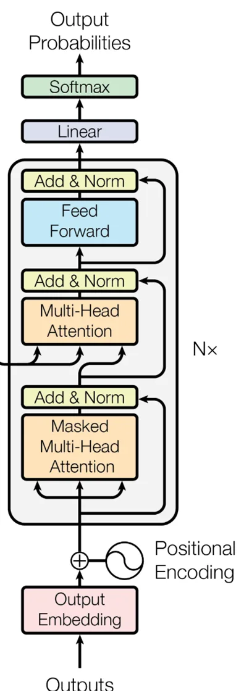

In [92]:
# Building Decoder Block
class DecoderBlock(nn.Module):
  # The DecoderBlock takes in two MultiHeadAttentionBlock. One is self-attention, while the other is cross-attention.
  # It also takes in the feed-forward block and the dropout rate
  def __init__(self,  self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
      super().__init__()
      self.self_attention_block = self_attention_block
      self.cross_attention_block = cross_attention_block
      self.feed_forward_block = feed_forward_block
      self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)]) # List of three Residual Connections with dropout rate

  def forward(self, x, encoder_output, src_mask, tgt_mask):

      # Self-Attention block with query, key, and value plus the target language mask
      x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))

      # The Cross-Attention block using two 'encoder_ouput's for key and value plus the source language mask. It also takes in 'x' for Decoder queries
      x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))

      # Feed-forward block with residual connections
      x = self.residual_connections[2](x, self.feed_forward_block)
      return x

In [93]:
# Building Decoder
# A Decoder can have several Decoder Blocks
class Decoder(nn.Module):
    # The Decoder takes in instances of 'DecoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()

        # Storing the 'DecoderBlock's
        self.layers = layers
        self.norm = LayerNormalization() # Layer to normalize the output

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Iterating over each DecoderBlock stored in self.layers
        for layer in self.layers:
            # Applies each DecoderBlock to the input 'x' plus the encoder output and source and target masks
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x) # Returns normalized output

###**`Linear Layer`**

The decoder stack outputs a vector of floats. How do we turn that into a word? That’s the job of the final Linear layer which is followed by a Softmax Layer.

The Linear layer is a simple fully connected neural network that projects the vector produced by the stack of decoders, into a much, much larger vector called a logits vector.

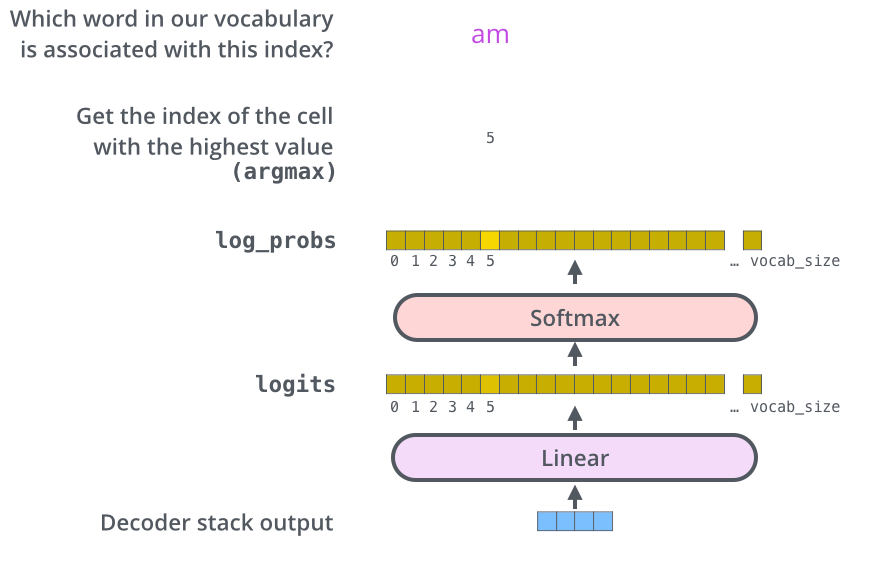

In [94]:
# Buiding Linear Layer
class ProjectionLayer(nn.Module):
  def __init__(self, d_model: int, vocab_size: int) -> None: # Model dimension and the size of the output vocabulary
      super().__init__()
      self.proj = nn.Linear(d_model, vocab_size) # Linear layer for projecting the feature space of 'd_model' to the output space of 'vocab_size'
  def forward(self, x):
      return torch.log_softmax(self.proj(x), dim = -1) # Applying the log Softmax function to the output

#**`Building the Transformer`**

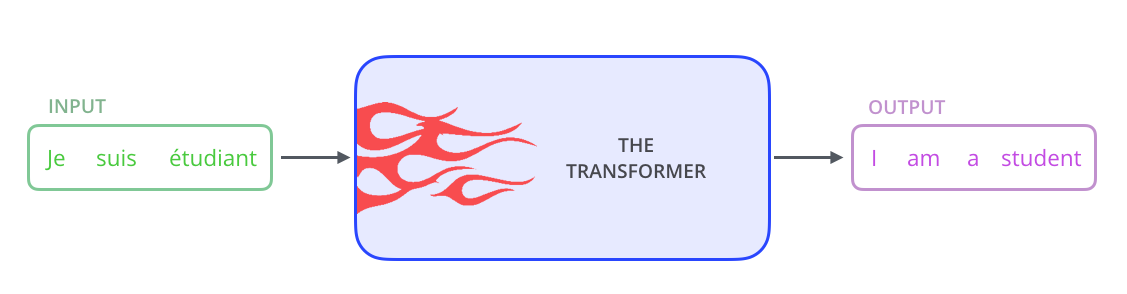

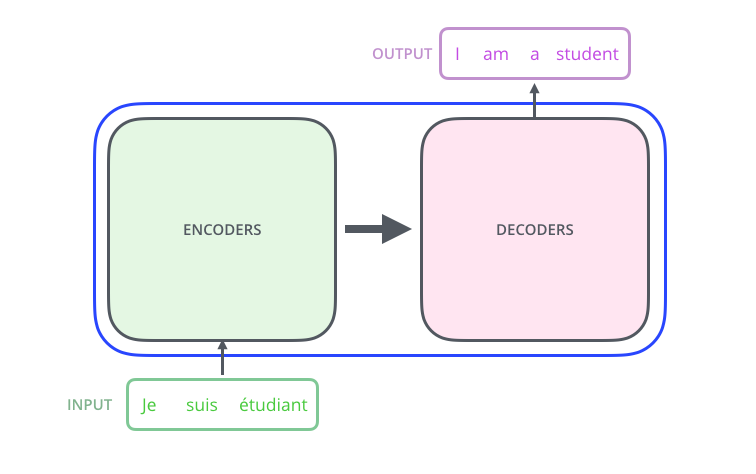

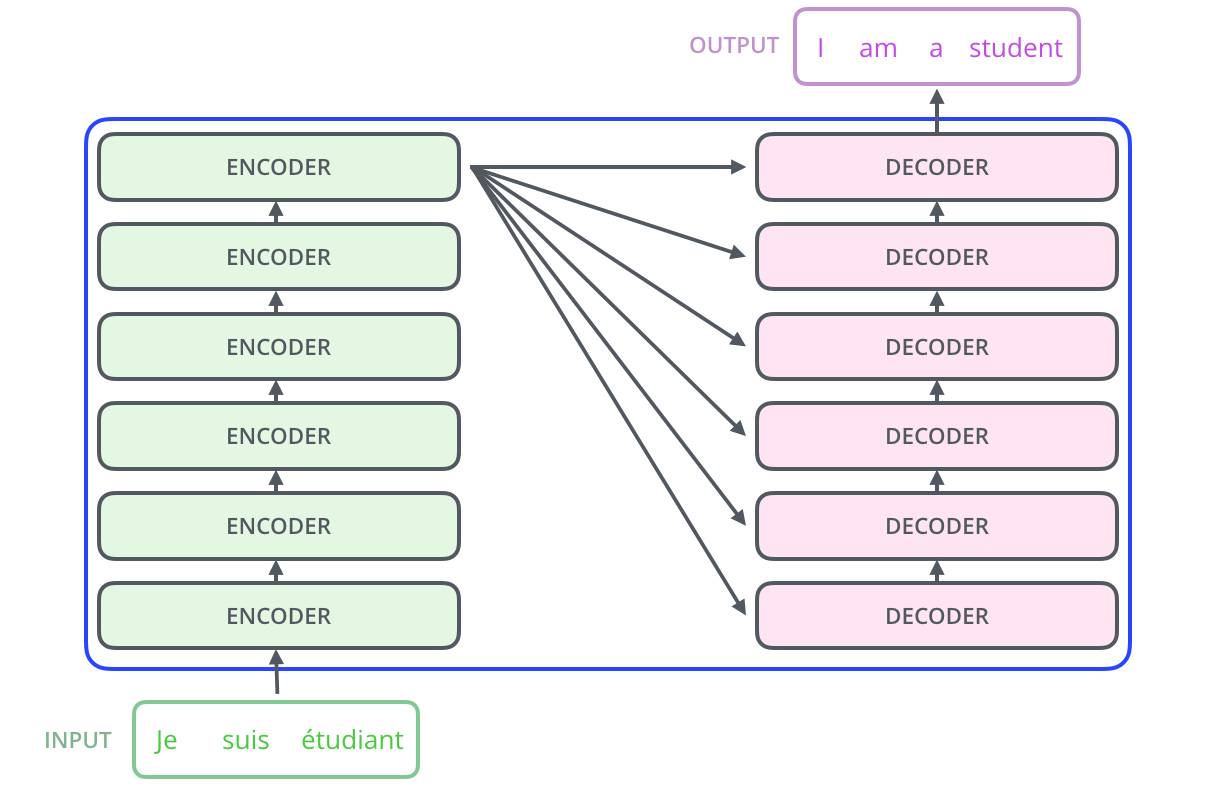

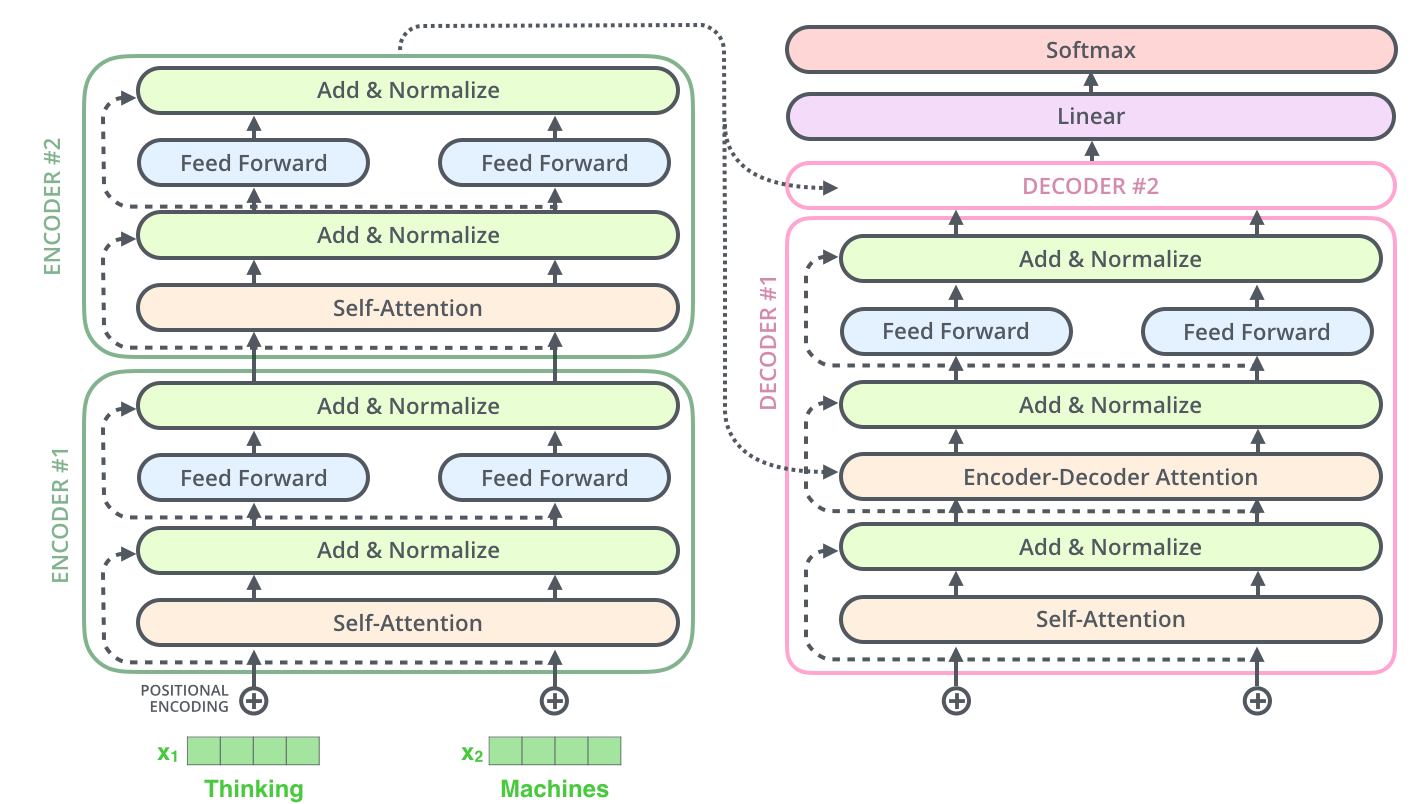

In [95]:
# Creating the Transformer Architecture
class Transformer(nn.Module):

    # This takes in the encoder and decoder, as well the embeddings for the source and target language.
    # It also takes in the Positional Encoding for the source and target language, as well as the projection layer
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    # Encoder
    def encode(self, src, src_mask):
        src = self.src_embed(src) # Applying source embeddings to the input source language
        src = self.src_pos(src) # Applying source positional encoding to the source embeddings
        return self.encoder(src, src_mask) # Returning the source embeddings plus a source mask to prevent attention to certain elements

    # Decoder
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt) # Applying target embeddings to the input target language (tgt)
        tgt = self.tgt_pos(tgt) # Applying target positional encoding to the target embeddings

        # Returning the target embeddings, the output of the encoder, and both source and target masks
        # The target mask ensures that the model won't 'see' future elements of the sequence
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    # Applying Projection Layer with the Softmax function to the Decoder output
    def project(self, x):
        return self.projection_layer(x)

In [96]:
# Building & Initializing Transformer

# Definin function and its parameter, including model dimension, number of encoder and decoder stacks, heads, etc.
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:

    # Creating Embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size) # Source language (Source Vocabulary to 512-dimensional vectors)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size) # Target language (Target Vocabulary to 512-dimensional vectors)

    # Creating Positional Encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout) # Positional encoding for the source language embeddings
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout) # Positional encoding for the target language embeddings

    # Creating EncoderBlocks
    encoder_blocks = [] # Initial list of empty EncoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combine layers into an EncoderBlock
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block) # Appending EncoderBlock to the list of EncoderBlocks

    # Creating DecoderBlocks
    decoder_blocks = [] # Initial list of empty DecoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block) # Appending DecoderBlock to the list of DecoderBlocks

    # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    # Creating projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space

    # Creating the transformer by combining everything above
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer # Assembled and initialized Transformer. Ready to be trained and validated!

###**`Tokenization`**

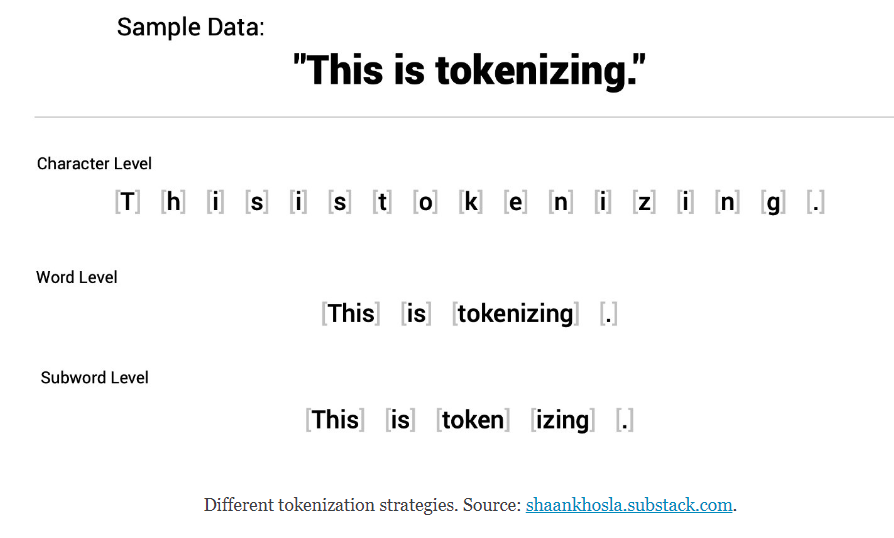

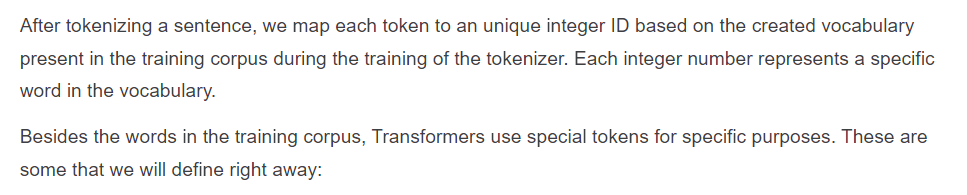

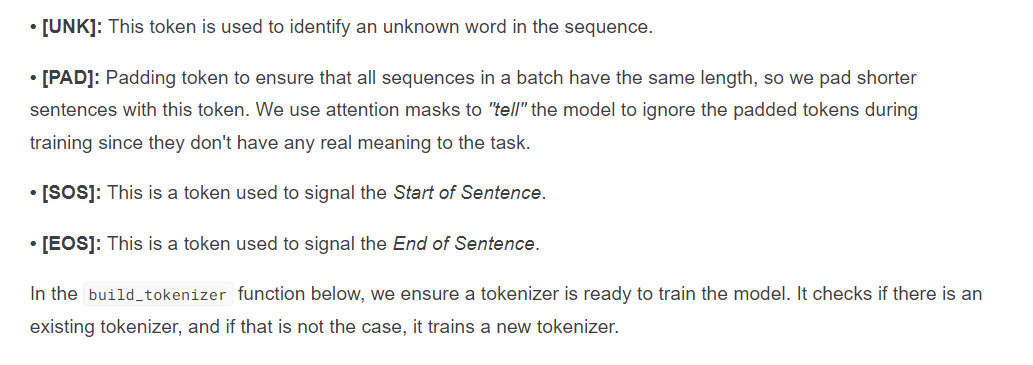

In [97]:
def build_tokenizer(config, ds, lang):
  # Crating a file path for the tokenizer
  tokenizer_path = Path(config['tokenizer_file'].format(lang))

  # Checking if Tokenizer already exists
  if not Path.exists(tokenizer_path):
    # If it doesn't exist, we create a new one
    tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))  # Initializing a new world-level tokenizer
    tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace

    # Creating a trainer for the new tokenizer
    trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                     "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens
    # Training new tokenizer on sentences from the dataset and language specified
    tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
    tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
  else:
    tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
  return tokenizer # Returns the loaded tokenizer or the trained tokenizer

In [98]:
# Iterating through dataset to extract the original sentence and its translation
def get_all_sentences(ds, lang):
  for pair in ds:
    yield pair['translation'][lang]

###**`Loading Dataset`**

In [99]:
def get_ds(config):
    """
    Prepares the dataset, tokenizers, and dataloaders for training and validation of a bilingual sequence-to-sequence model.

    Args:
        config (dict): A configuration dictionary containing the following keys:
            - `lang_src` (str): Source language code (e.g., 'en').
            - `lang_tgt` (str): Target language code (e.g., 'fr').
            - `tokenizer_file` (str): File path template for saving/loading the tokenizer.
            - `seq_len` (int): Maximum sequence length for tokenized sentences.
            - `batch_size` (int): Batch size for the training DataLoader.

    Returns:
        tuple: A tuple containing:
            - train_dataloader (torch.utils.data.DataLoader): DataLoader for training data.
            - val_dataloader (torch.utils.data.DataLoader): DataLoader for validation data.
            - tokenizer_src (Tokenizer): Tokenizer for the source language.
            - tokenizer_tgt (Tokenizer): Tokenizer for the target language.

    Workflow:
        1. Load the OpusBooks dataset for the specified language pair from the `datasets` library.
        2. Create or load tokenizers for both the source and target languages.
        3. Split the dataset into training and validation sets (90% training, 10% validation).
        4. Process the data using a custom `BilingualDataset` class to handle tokenization and sequence length constraints.
        5. Compute the maximum sentence lengths in the source and target languages for reference.
        6. Create DataLoaders for training and validation, with appropriate batch sizes.

    Example:
        config = {
            "lang_src": "en",
            "lang_tgt": "fr",
            "tokenizer_file": "./tokenizer_{lang}.json",
            "seq_len": 128,
            "batch_size": 32
        }
        train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    """
    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation

    # Randomly splitting the dataset
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0

    for pair in ds_raw:
      src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
      tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
      max_len_src = max(max_len_src, len(src_ids))
      max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers

###**`Casual Mask`**
casual_mask generates a causal mask to ensure that in sequence modeling, a token at position
𝑖
i can only attend to itself and tokens before it. This is typically used in autoregressive tasks like language modeling.

In [100]:
def casual_mask(size):
  """
  Creates a causal mask for sequence modeling, ensuring that each token can only attend to itself
  and preceding tokens in the sequence.

  Args:
      size (int): The size of the sequence (length of tokens).

  Returns:
      torch.Tensor: A boolean mask of shape (1, size, size), where:
          - `True` indicates allowed positions for attention.
          - `False` indicates disallowed positions for attention.

  Example:
      >>> mask = casual_mask(4)
      >>> print(mask)
      tensor([[[ True, False, False, False],
                [ True,  True, False, False],
                [ True,  True,  True, False],
                [ True,  True,  True,  True]]])
  """
  # Creating a square matrix of dimensions 'size x size' filled with ones
  mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
  return mask == 0

In [101]:
casual_mask(10)

tensor([[[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]])

In [102]:
from torch.utils.data import Dataset
from typing import Any

class BilingualDataset(Dataset):

    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)


    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)

    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Computing how many padding tokens need to be added to the tokenized texts
        # Source tokens
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 # Subtracting the '[SOS]' special token

        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')

        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
            self.sos_token, # inserting the '[SOS]' token
            torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
            self.eos_token, # Inserting the '[EOS]' token
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )

        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]

        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens

            ]
        )

        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }

###**`Validation Loop`**

In [103]:
#Function to obtain the most probable next token
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break

        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)

        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder

In [104]:
# Function to evaluate the model on the validation dataset
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0 # Initializing counter to keep track of how many examples have been processed

    console_width = 80 # Fixed witdh for printed messages

    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'

            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output

            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            # After two examples, we break the loop
            if count == num_examples:
                break

###**`Training Loop`**

In [105]:
def get_model(config, vocab_src_len, vocab_tgt_len):

    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

In [106]:
# Define settings for building and training the transformer model
def get_config():
    return{
        'batch_size': 8,
        'num_epochs': 5,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512, # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }


# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt" # Building filename
    return str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename

In [107]:
def train_model(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")

    # Creating model directory to store weights
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

    # Retrieving dataloaders and tokenizers for source and target languages using the 'get_ds' function
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)

    # Initializing model on the GPU using the 'get_model' function
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)

    # Initializing epoch and global step variables
    initial_epoch = 0
    global_step = 0

    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename) # Loading model

        # Sets epoch to the saved in the state plus one, to resume from where it stopped
        initial_epoch = state['epoch'] + 1
        # Loading the optimizer state from the saved model
        optimizer.load_state_dict(state['optimizer_state_dict'])
        # Loading the global step state from the saved model
        global_step = state['global_step']

    # Initializing CrossEntropyLoss function for training
    # We ignore padding tokens when computing loss, as they are not relevant for the learning process
    # We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)

    # Initializing training loop

    # Iterating over each epoch from the 'initial_epoch' variable up to
    # the number of epochs informed in the config
    for epoch in range(initial_epoch, config['num_epochs']):

        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')

        # For each batch...
        for batch in batch_iterator:
            model.train() # Train the model

            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)

            # Loading the target labels onto the GPU
            label = batch['label'].to(device)

            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})

            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Performing backpropagation
            loss.backward()

            # Updating parameters based on the gradients
            optimizer.step()

            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()

            global_step += 1 # Updating global step count

        # We run the 'run_validation' function at the end of each epoch
        # to evaluate model performance
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Saving model
        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        # Writting current model state to the 'model_filename'
        torch.save({
            'epoch': epoch, # Current epoch
            'model_state_dict': model.state_dict(),# Current model state
            'optimizer_state_dict': optimizer.state_dict(), # Current optimizer state
            'global_step': global_step # Current global step
        }, model_filename)

In [108]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments

Using device cuda


README.md:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.73M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Max length of source sentence: 309
Max length of target sentence: 274


Processing epoch 00: 100%|██████████| 3638/3638 [25:40<00:00,  2.36it/s, loss=6.296]


--------------------------------------------------------------------------------
SOURCE: It was mournful, indeed, to witness the subjugation of that vigorous spirit to a corporeal infirmity.
TARGET: Fui addolorata vedendo quello spirito vigoroso domato da un corpo infermo.
PREDICTED: Il signor Rochester era un ’ altra volta , e il suo tempo , e .
--------------------------------------------------------------------------------
SOURCE: A woman's steps were heard ascending the stairs.
TARGET: Sulla scala risonarono dei passi femminili.
PREDICTED: Il suo momento , , e si .


Processing epoch 01: 100%|██████████| 3638/3638 [25:38<00:00,  2.36it/s, loss=5.613]


--------------------------------------------------------------------------------
SOURCE: He waited impatiently to hear that she was married or was getting married soon, hoping that such news, like the drawing of an aching tooth, would quite cure him.
TARGET: Aspettava con ansia la notizia che si fosse sposata o stesse per sposarsi a giorni; sperava che una notizia simile, come l’estirpazione di un dente, finisse col guarirlo.
PREDICTED: Egli si mise a parlare di lei , e non si era stato più di , e che si era stato stato in cui era stato stato .
--------------------------------------------------------------------------------
SOURCE: They had agreed not to go away anywhere, but the longer they lived alone the more they both felt – especially in autumn when there were no visitors – that they would not be able to hold out and that a change was inevitable.
TARGET: Era stabilito tra di loro che non sarebbero andati in nessun posto; ma tutti e due sentivano che, quanto più avrebbero vissuto s

Processing epoch 02: 100%|██████████| 3638/3638 [25:38<00:00,  2.36it/s, loss=4.880]


--------------------------------------------------------------------------------
SOURCE: I address myself to you not as...' He was going to say, 'as an offended husband,' but, afraid of injuring his case thereby, he changed the expression to 'not as a statesman' (this sounded inappropriate) 'but simply as a man, a kind man and a Christian!
TARGET: Mi rivolgo a te adesso — “non come al marito offeso” voleva dire Stepan Arkad’ic, ma, temendo di rovinare la faccenda, cambiò — non come all’uomo di stato — il che risultò fuor di proposito — ma semplicemente all’uomo, all’uomo buono, al cristiano.
PREDICTED: Io non mi , ma non si era stato di parlare — ella disse , ma , senza volere , ma , senza volere , senza volere , senza volere , senza dubbio , ma non si , e , la sua vita , ma non si , e la sua vita .
--------------------------------------------------------------------------------
SOURCE: This was more than Levin could stand; he resolutely snatched the bottle out of the man's hands and r

Processing epoch 03: 100%|██████████| 3638/3638 [25:38<00:00,  2.36it/s, loss=4.267]


--------------------------------------------------------------------------------
SOURCE: Lord Ingram, like his sisters, is very tall; like them, also, he is handsome; but he shares Mary's apathetic and listless look: he seems to have more length of limb than vivacity of blood or vigour of brain.
TARGET: Lord Ingram era alto e bello come le sorelle, ma aveva l'apatia della minore e pareva privo di vivacità e di vigore.
PREDICTED: " , perché è la sua signora Reed , e la sua signora , è un ' espressione di Diana ; ma la signorina Ingram è un ' espressione di e di .
--------------------------------------------------------------------------------
SOURCE: And in the end they were all received again...
TARGET: E andò a finire che tutti li ricevevano.
PREDICTED: E in questo momento si tutto ...


Processing epoch 04: 100%|██████████| 3638/3638 [25:40<00:00,  2.36it/s, loss=4.954]


--------------------------------------------------------------------------------
SOURCE: Dreadful as his emaciation and illness had previously made Nicholas, he was now still thinner and weaker.
TARGET: Per quanto spaventoso fosse anche prima suo fratello Nikolaj per la magrezza e l’aria malandata, in quel momento era ancora più smagrito, ancora più debole.
PREDICTED: la sua relazione e la sua malattia , che era stata da pranzo , e che era stata più semplice e semplice .
--------------------------------------------------------------------------------
SOURCE: And where is Mr. Rochester?
TARGET: Ov'era il signor Rochester?
PREDICTED: E dove è il signor Rochester ?
